In [1]:
import time
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For language conversion
from langdetect import detect
from autocorrect import Speller
from deep_translator import GoogleTranslator

### 0. Understanding the Business Problem
Uber Inc in the US wants to know:

- the major complaints premium users have about their cab services,
- how these impact service ratings.

We as (technical) consultants to Uber. have to:  
- [a] analyze text reviews of Uber cabs’ US services,  
- [b] relate whether and which different features of these reviews impact overall ratings  
- [c] pinpoint possible areas of improvement.

### 1. Pre-processing: 
- Examine the dataset. 
- ID the columns of interest. 
- Drop special characters, html junk etc. 
- Perform any other preprocessing and text-cleaning activity you think fits this context.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/uber_reviews_itune.csv",
                 encoding='cp1252')
df.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


Columns of interest:  
1. Title - Brief summary about the review
2. Rating - Label for supervised learning
3. Review - To extract the sentiment of the complaint
4. Date - Extracting weekday or weekend may give better insight on nature of review

### Data Cleaning

In [3]:
df1 = df.drop(['Author_Name','Author_URL','App_Version'],axis=1)
df1.head()

,Title,Rating,Review,Date
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,Free offer,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,bad,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


In [4]:
def language_translater(text):
    translated = GoogleTranslator(source=detect(text), target='en').translate(text)
    return translated

%%time
df1.Review = df1.Review.apply(lambda text: language_translater(text))
df1.Title = df1.Title.apply(lambda text: language_translater(text))

In [6]:
# Replacing emoticon with its respective meaning
df_emojis = pd.read_csv("https://raw.githubusercontent.com/Kenrich005/Uber_reviews_textanalytics/main/emoji_description.csv")
df_emojis['Code'] = df_emojis['Code'].str.replace('+','+000')
df_emojis.head()

,Code,CLDR Short Name
0,<U+0001F600>,grinning face
1,<U+0001F603>,grinning face with big eyes
2,<U+0001F604>,grinning face with smiling eyes
3,<U+0001F601>,beaming face with smiling eyes
4,<U+0001F606>,grinning squinting face


In [7]:
# Replacing emoticon with its respective meaning
to_replace = df_emojis.Code.tolist()
replace_with = df_emojis['CLDR Short Name'].tolist()

# using zip() to convert lists to dictionary
res = dict(zip(to_replace, replace_with))

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(str(i), j + " ")
    return text

In [8]:
df1.Review = df1.Review.apply(lambda text: replace_all(text, res))
df1.Title = df1.Title.apply(lambda text: replace_all(text, res))
df1.Review[1]

'If I’m not eligible for the offer Stop flooding my email with this false information pouting face pouting face pouting face '

In [9]:
df1.Review = df1.Review.str.split('<').str[0]
df1.Title = df1.Title.str.split('<').str[0]
df1.shape

(490, 4)

In [10]:
df1.Review[149]

''

In [11]:
df1['Review'].replace('', np.nan, inplace=True)
df1['Title'].replace('', np.nan, inplace=True)
df1.dropna(subset=['Review'], inplace=True)
df1 = df1.reset_index(drop=True)
df1.shape

(489, 4)

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# define unit func to process one doc
from nltk import sent_tokenize, word_tokenize
def vader_unit_func(doc0,column_name):
    sents_list0 = sent_tokenize(doc0)
    vs_doc0 = []
    sent_ind = []
    for i in range(len(sents_list0)):
        vs_sent0 = analyzer.polarity_scores(sents_list0[i])
        vs_doc0.append(vs_sent0)
        sent_ind.append(i)
        
    # obtain output as DF    
    doc0_df = pd.DataFrame(vs_doc0)
    doc0_df.columns = [x+column_name for x in doc0_df.columns]
    doc0_df.insert(0, 'sent_index', sent_ind)  # insert sent index
    doc0_df.insert(doc0_df.shape[1], 'sentence', sents_list0)
    return(doc0_df)

# define wrapper func
def vader_wrap_func(corpus0,column_name):
    
    # use ifinstance() to check & convert input to DF
    if isinstance(corpus0, list):
        corpus0 = pd.DataFrame({'text':corpus0})
    
    # define empty DF to concat unit func output to
    vs_df = pd.DataFrame()    
    
    # apply unit-func to each doc & loop over all docs
    for i1 in range(len(corpus0)):
        doc0 = str(corpus0.iloc[i1])
        vs_doc_df = vader_unit_func(doc0,column_name)  # applying unit-func
        vs_doc_df.insert(0, 'doc_index', i1)  # inserting doc index
        vs_df = pd.concat([vs_df, vs_doc_df], axis=0)
        
    return(vs_df)

In [13]:
# test-drive wrapper func
title_sentiment = vader_wrap_func(df1.Title,'_title').groupby('doc_index').sum()
review_sentiment = vader_wrap_func(df1.Review,'_review').groupby('doc_index').sum()
df1 = pd.concat([df1,review_sentiment,title_sentiment],axis=1)
print(df1.shape)
df1.head()

(489, 14)


,Title,Rating,Review,Date,sent_index,neg_review,neu_review,pos_review,compound_review,sent_index,neg_title,neu_title,pos_title,compound_title
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14,3,0.000,2.876,0.124,0.1406,0,0.877,0.123,0.000,-0.7964
1,Free offer,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17,0,0.099,0.901,0.000,-0.2960,0,0.000,0.233,0.767,0.5106
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38,0,0.179,0.821,0.000,-0.3400,0,0.000,1.000,0.000,0.0000
3,bad,1,i had my rides canceled back to back. they the...,08-12-2020 01:01,10,1.167,3.592,0.241,-0.1617,0,1.000,0.000,0.000,-0.5423
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,15-12-2020 04:02,21,0.908,5.614,0.478,-0.4906,0,0.265,0.735,0.000,-0.2023


In [14]:
# Converting Date into datetime format
df1['Date'] =  pd.to_datetime(df1['Date'], format='%d-%m-%Y %H:%M')

# Splitting date into multiple parts of day
df1['Isweekend'] = np.where(df1.Date.dt.dayofweek>4,1,0)
df1['Late_night'] = np.where(df1.Date.dt.hour<4,1,0)
df1['Early_mrng'] = np.where(df1.Date.dt.hour.between(4,8),1,0)
df1['Morning'] = np.where(df1.Date.dt.hour.between(8,12),1,0)
df1['Noon'] = np.where(df1.Date.dt.hour.between(12,16),1,0)
df1['Eve'] = np.where(df1.Date.dt.hour.between(16,20),1,0)
df1['Night'] = np.where(df1.Date.dt.hour>20,1,0)
df1.head()

,Title,Rating,Review,Date,sent_index,neg_review,neu_review,pos_review,compound_review,sent_index,...,neu_title,pos_title,compound_title,Isweekend,Late_night,Early_mrng,Morning,Noon,Eve,Night
0,Dishonest and Disgusting,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29 01:14:00,3,0.000,2.876,0.124,0.1406,0,...,0.123,0.000,-0.7964,0,1,0,0,0,0,0
1,Free offer,2,If I’m not eligible for the offer Stop floodin...,2021-01-01 23:17:00,0,0.099,0.901,0.000,-0.2960,0,...,0.233,0.767,0.5106,0,0,0,0,0,0,1
2,Inaccurate,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15 23:38:00,0,0.179,0.821,0.000,-0.3400,0,...,1.000,0.000,0.0000,0,0,0,0,0,0,1
3,bad,1,i had my rides canceled back to back. they the...,2020-12-08 01:01:00,10,1.167,3.592,0.241,-0.1617,0,...,0.000,0.000,-0.5423,0,1,0,0,0,0,0
4,Double charged me for an order,1,Two of the same orders was added by accident. ...,2020-12-15 04:02:00,21,0.908,5.614,0.478,-0.4906,0,...,0.735,0.000,-0.2023,0,0,1,0,0,0,0


In [15]:
df1['Isnegative'] = np.where((df1.compound_review<0)|(df1.compound_title<0),1,0)

df1=df1.drop(['sent_index','Title','Review','Date'],axis=1)
df1.head()

,Rating,neg_review,neu_review,pos_review,compound_review,neg_title,neu_title,pos_title,compound_title,Isweekend,Late_night,Early_mrng,Morning,Noon,Eve,Night,Isnegative
0,1,0.000,2.876,0.124,0.1406,0.877,0.123,0.000,-0.7964,0,1,0,0,0,0,0,1
1,2,0.099,0.901,0.000,-0.2960,0.000,0.233,0.767,0.5106,0,0,0,0,0,0,1,1
2,2,0.179,0.821,0.000,-0.3400,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,1,1
3,1,1.167,3.592,0.241,-0.1617,1.000,0.000,0.000,-0.5423,0,1,0,0,0,0,0,1
4,1,0.908,5.614,0.478,-0.4906,0.265,0.735,0.000,-0.2023,0,0,1,0,0,0,0,1


### Preliminary Regression Model


In [16]:
y = df1.Rating
X = df1.drop('Rating', axis=1)
y.shape, X.shape

((489,), (489, 16))

In [17]:
X.columns

Index(['neg_review', 'neu_review', 'pos_review', 'compound_review',
       'neg_title', 'neu_title', 'pos_title', 'compound_title', 'Isweekend',
       'Late_night', 'Early_mrng', 'Morning', 'Noon', 'Eve', 'Night',
       'Isnegative'],
      dtype='object')

In [18]:
X_cat = X[['Isweekend','Late_night', 'Early_mrng', 'Morning', 'Noon', 'Eve', 'Night','Isnegative']]
X_cont = X.drop(X_cat,axis=1)
X_cont.columns

Index(['neg_review', 'neu_review', 'pos_review', 'compound_review',
       'neg_title', 'neu_title', 'pos_title', 'compound_title'],
      dtype='object')

In [19]:
# Standardizing continuous variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = pd.DataFrame(sc.fit_transform(X_cont), columns=X_cont.columns)
X_sc.head()

,neg_review,neu_review,pos_review,compound_review,neg_title,neu_title,pos_title,compound_title
0,-0.887013,-0.082705,-0.412907,0.361095,1.940023,-1.502055,-0.405811,-2.063536
1,-0.666391,-0.759076,-0.724868,-0.161737,-0.762349,-1.218965,3.265131,1.939506
2,-0.488111,-0.786474,-0.724868,-0.214428,-0.762349,0.754943,-0.405811,0.375655
3,1.713652,0.162501,-0.118557,-0.000912,2.319033,-1.818601,-0.405811,-1.285286
4,1.136469,0.854969,0.477691,-0.394773,0.054217,0.072954,-0.405811,-0.243944


In [20]:
import statsmodels.api as sm
X_c = sm.add_constant(pd.concat([X_sc,X_cat],axis=1))
model = sm.OLS(y,X_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.632
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           3.59e-11
Time:                        21:33:13   Log-Likelihood:                -655.72
No. Observations:                 489   AIC:                             1345.
Df Residuals:                     472   BIC:                             1417.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6989      0.219      7.755      0.000       1.268       2.129
neg_review         -0.1197      0.070     -1.706      0.089      -0.258       0.018
neu_review         -0.0441      0.055     -0.795      0.427      -0.153       0.065
pos_review          0.1403      0.076      1.856      0.064      -0.008       0.289
compound_review     0.0388      0.086      0.453      0.651      -0.130       0.207
neg_title          -0.0700      0.118     -0.595      0.552      -0.301       0.161
neu_title          -0.1101      0.084     -1.310      0.191      -0.275       0.055
pos_title           0.0595      0.078      0.759      0.448      -0.095       0.213
compound_title      0.1781      0.112      1.596      0.111      -0.041       0.397
Isweekend          -0.0615      0.096     -0.644      0.520      -0.249       0.126
Late_night          0.0661      0.223      0.297      0.767      -0.372       0.504
Early_mrng         -0.2475      0.214     -1.154      0.249      -0.669       0.174
Morning            -0.2672      0.184     -1.451      0.147      -0.629       0.095
Noon               -0.0790      0.154     -0.514      0.608      -0.381       0.223
Eve                -0.0773      0.196     -0.395      0.693      -0.462       0.307
Night               0.0006      0.222      0.003      0.998      -0.436       0.437
Isnegative         -0.1123      0.133     -0.843      0.400      -0.374       0.149
==============================================================================
Omnibus:                      141.300   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.961
Skew:                           1.537   Prob(JB):                     1.34e-67
Kurtosis:                       5.381   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Calculating VIF

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
   
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'].sort_values()

    return(vif)

In [22]:
calc_vif(X)

,variables,VIF
0,neg_review,4.837862
1,neu_review,3.596789
2,pos_review,4.793796
3,compound_review,4.200654
4,neg_title,9.314920
5,neu_title,8.312350
6,pos_title,3.538754
7,compound_title,7.726027
8,Isweekend,1.500537
9,Late_night,3.350728


Generally, a VIF above 4 or tolerance below 0.25 indicates that multicollinearity might exist, and further investigation is required.   
When VIF is higher than 10 or tolerance is lower than 0.1, there is significant multicollinearity that needs to be corrected.  
  
Since all the above variables have VIF below 4 and above 0.25, we can be assured that there is no multicollinearity.

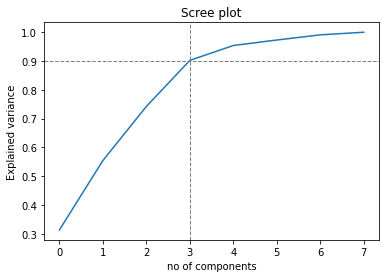

In [23]:
# Applying PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA().fit(X_sc)

# Plot the scree plot to see how many components explain how much variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("no of components")
plt.ylabel("Explained variance")
plt.title("Scree plot")
plt.xticks(np.arange(0,8,1))
plt.axhline(y=0.9, c='grey', lw=1, linestyle='dashed')
plt.axvline(x=3, c='grey', lw=1, linestyle='dashed');

In [24]:
# Since 3 components explain around 90% of the data, we choose 3 PCA components
pca1 = PCA(n_components=3)
X_pca = pca1.fit_transform(X_sc)
X_pca = pd.DataFrame(X_pca,columns=['PCA1','PCA2','PCA3'])
X_pca.head()

,PCA1,PCA2,PCA3
0,-2.619897,0.049648,-2.005806
1,2.132843,-0.001572,-1.495371
2,0.667369,-1.515984,0.342462
3,-3.110741,1.364179,-0.535916
4,-0.561887,0.962196,1.151722


In [25]:
X_fin = pd.concat([X_pca, X_cat],axis=1)
X_pca.shape, X_cat.shape, X_fin.shape

((489, 3), (489, 8), (489, 11))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fin,y,test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((342, 11), (147, 11), (342,), (147,))

In [27]:
# We will save the model performance metrics in a DataFrame

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
Model = []
RMSE = []
R_sq = []
cv = KFold(5)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean()))
    R_sq.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [28]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','XGBRegressor']

models = [LinearRegression(), Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),XGBRegressor()]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, X_train, y_train)

Reference: https://www.kaggle.com/swatisinghalmav/best-of-8-regression-models-to-predict-strength

In [29]:
evaluation = pd.DataFrame({'Model': Model,'RMSE': RMSE,'R Squared': R_sq})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

SyntaxError: invalid syntax (<ipython-input-29-5db9c16462e4>, line 3)

## End